In [1]:
import torch
import torch.nn as nn
from dataset import get_dataloader, get_label_model, download_dataset
from model import UNetCore
import os
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ds_path = "../dataset/cityscapes_images/"

if not os.path.exists(ds_path): #noqa
    os.makedirs(ds_path)
    url = "https://www.kaggle.com/api/v1/datasets/download/dansbecker/cityscapes-image-pairs"
    filename = ds_path + "cityscapes-image-pairs.zip"
    download_dataset(url, filename)

    #unzip the dataset
    import zipfile
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(ds_path)


dataset_path = os.path.join(ds_path, "cityscapes_data/")
train_path = os.path.join(dataset_path, "train/")
val_path = os.path.join(dataset_path, "val/")

In [3]:
# HPrams
epochs = 60
lr = 0.001
ncluster = 10
batch_size = 16


In [4]:
label_model = get_label_model(n_clusters=ncluster)

In [5]:
dataloader = get_dataloader(train_path, label_model, batch_size=batch_size, shuffle=True)

In [ ]:
model = UNetCore(3, 10).to(device)
# model = UNet(10).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
for epoch in range(epochs):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    total_loss = 0
    for idx, (data, target) in loop:
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = loss_fn(output, target)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.item()

        if idx % 10 == 0:
            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch}/{epochs}] Loss: {total_loss/len(dataloader)}")

Epoch [0/10] Loss: 0.1845129693067202


Epoch [1/10] Loss: 0.179300959552488


Epoch [2/10] Loss: 0.17855650498982398


Epoch [3/10] Loss: 0.1775206379512305


Epoch [4/10] Loss: 0.17407557800892862


Epoch [5/10] Loss: 0.19175850167389838


Epoch [6/10] Loss: 0.19466619265656318


Epoch [7/10] Loss: 0.16263252881265455


Epoch [8/10] Loss: 0.15399317735786078


Epoch [9/10] Loss: 0.14876690883469837


In [11]:
torch.save(model.state_dict(), "model.pth")

In [12]:
# validaiton
dataset = get_dataloader(val_path, label_model, batch_size=batch_size, shuffle=True)

In [13]:
X, Y = next(iter(dataset))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])
torch.Size([16, 256, 256])


In [15]:
from torchvision import transforms
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

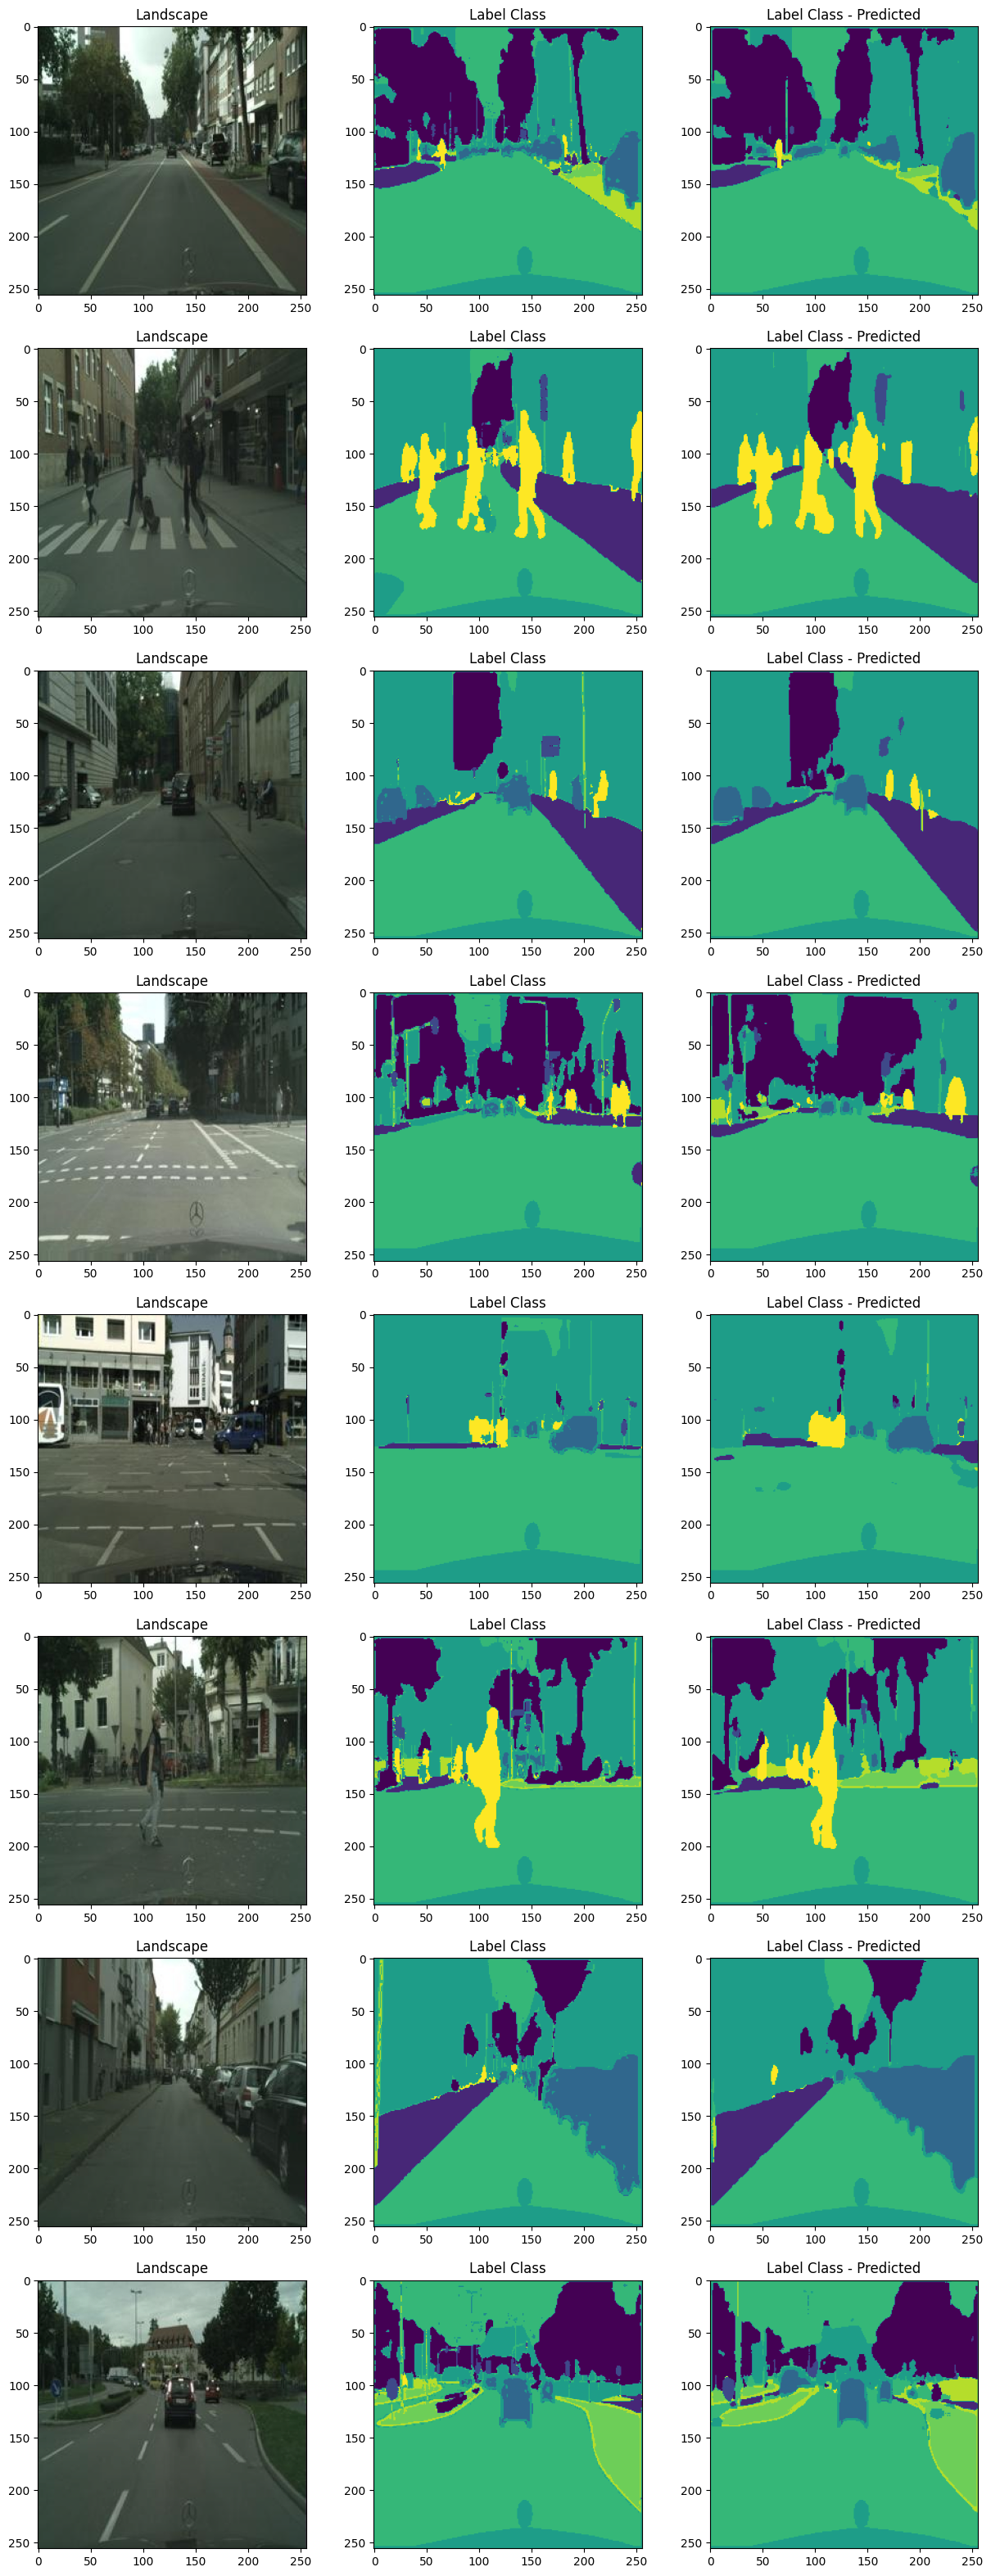

In [16]:
from matplotlib import pyplot as plt
test_batch_size = 8
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")